In [1]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
from pandas.tools.plotting import scatter_matrix

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [20]:
# get train & test csv files as a DataFrame
titanic_df = pd.read_csv("../Data/train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("../Data/test.csv", dtype={"Age": np.float64}, )

## Basic Cleaning ##

Drop unnecessary columns or rows that won't be useful in analysis and prediction

- Remove PassengerId from train as it is an index and has no value. 
- Cabin might be a potential for removing given there are so many missing values however we need to investigate it further.
- Remove the 2 entries from the training set with missing Embarked values as the % of entries it impacts is so low.

In [21]:
titanic_df = titanic_df.drop(['PassengerId'], axis=1)
titanic_df = titanic_df.dropna(subset=['Embarked'])
# titanic_df.info() # verify

In [22]:
# Sex

# Convert string values to numerical one 
titanic_df['Sex'] = titanic_df['Sex'].map({'male':1,'female':0}).astype(int)
test_df['Sex'] = test_df['Sex'].map({'male':1,'female':0}).astype(int)

# Age

# Replace empty age values with the mean - should verify mean / median. Perhaps take by analysing
# name to determin title e.g. Mrs. is probably older than Miss.
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
test_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

# TODO: Visualise and Analyse
# Name
# Age
# SibSp
# Parch
# Ticket
# Fare

# replace missing fare value with the mean.
titanic_df.Fare.fillna(titanic_df.Fare.mean(),inplace=True)
test_df.Fare.fillna(test_df.Fare.mean(),inplace=True)
    
# Cabin
# Embarked
ports = pd.get_dummies(titanic_df['Embarked'], prefix='Embarked')
titanic_df = pd.concat([titanic_df, ports], axis = 1)
ports = pd.get_dummies(test_df['Embarked'], prefix='Embarked')
test_df = pd.concat([test_df, ports], axis = 1)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int32
Age            418 non-null int32
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Embarked_C     418 non-null float64
Embarked_Q     418 non-null float64
Embarked_S     418 non-null float64
dtypes: float64(4), int32(2), int64(4), object(4)
memory usage: 42.5+ KB


In [23]:
# Verify totals
print("Survived: " + str(len(titanic_df[titanic_df['Survived'] == 1])))
print("Died: " + str(len(titanic_df[titanic_df['Survived'] == 0])))
print("Total: " + str(len(titanic_df)))


Survived: 340
Died: 549
Total: 889


## Create New Features ##

In [24]:
# TODO:

## Final correction of data ##

We need to remove some values such as string entries. Most of this code should be done smarter elsewhere!

In [25]:
# drop string values - these should be convirted
titanic_df = titanic_df.drop(["Name", "Ticket", "Cabin", "Embarked"],axis=1)
titanic_df = titanic_df.dropna()
test_df = test_df.drop(["Name", "Ticket", "Cabin", "Embarked"],axis=1)
test_df = test_df.dropna()

In [26]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
Survived      889 non-null int64
Pclass        889 non-null int64
Sex           889 non-null int32
Age           889 non-null int32
SibSp         889 non-null int64
Parch         889 non-null int64
Fare          889 non-null float64
Embarked_C    889 non-null float64
Embarked_Q    889 non-null float64
Embarked_S    889 non-null float64
dtypes: float64(4), int32(2), int64(4)
memory usage: 69.5 KB


## Create Final Train and Test Datasets ##

In [27]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

## Build Models and Test ##
First some helper methods

In [28]:
# Run and evaluate model
def evaluate_model(model, X_train, Y_train, X_test):
    # fit the model against the training data
    model.fit(X_train, Y_train)

    # get scores based upon 5 fold cross validation
    scores = cross_validation.cross_val_score(model, X_train, Y_train, cv=5)
    print("Fold Accuracies: " + str(scores))
    print("Accuracy: %0.2f (+/- %0.2f @2std)" % (scores.mean(), scores.std() * 2))

    # Compute confusion matrix
    prediction = cross_validation.cross_val_predict(model, X_train, Y_train)
    cm = confusion_matrix(Y_train, prediction)
    print('Confusion matrix, without normalization')
    print(cm)
    plot_confusion_matrix(cm, np.array(["Died", "Survived"]))

    # predics test classes
    Y_pred = model.predict(X_test)
    return Y_pred

# Plot confusion matrix
def plot_confusion_matrix(cm, tickLabels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tickLabels))
    plt.xticks(tick_marks, tickLabels, rotation=45)
    plt.yticks(tick_marks, tickLabels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Baseline (ZeroR) classification ##

At this stage out training set has **889** entries of which the most common output class is that they died with **549** entries.

We could achieve an accuracy of **61.75%** by just predicting 'died' for all cases so this should be our absolute baseline! 

## Gender Based Model ##
Given the percentage of woman who survided was a lot higher than men, what happens if we just predict that all women lived and all men died

In [29]:
women = titanic_df[titanic_df['Sex']==0]
print('Number of females:', len(women))
men = titanic_df[titanic_df['Sex']==1]
print('Number of males:', len(men))

proportion_women_survived = np.sum(women['Survived'].tolist()) / np.size(women['Survived'].tolist()) 
proportion_men_survived = np.sum(men['Survived'].tolist()) / np.size(men['Survived'].tolist()) 

print('Proportion of women who survived is %s' % proportion_women_survived)
print('Proportion of men who survived is %s' % proportion_men_survived)

def predict(row):
    if row['Sex'] == 0:
        return 1
    else:
        return 0

gender_test_df = test_df
gender_test_df['Survived'] = gender_test_df.apply(predict, axis=1)

gender_submission = gender_test_df[['PassengerId', 'Survived']]
gender_submission.to_csv('gender_predictions.csv', index=False)

Number of females: 312
Number of males: 577
Proportion of women who survived is 0.740384615385
Proportion of men who survived is 0.188908145581


## Machine Learning Models ##

Fold Accuracies: [ 0.78089888  0.80337079  0.78089888  0.76966292  0.82485876]
Accuracy: 0.79 (+/- 0.04 @2std)
Confusion matrix, without normalization
[[474  75]
 [113 227]]


,Features,Coefficient Estimate
0,Pclass,-0.872758
1,Sex,-2.506771
2,Age,-0.030263
3,SibSp,-0.294106
4,Parch,-0.076919
5,Fare,0.003808
6,Embarked_C,1.195413
7,Embarked_Q,1.031368
8,Embarked_S,0.815128


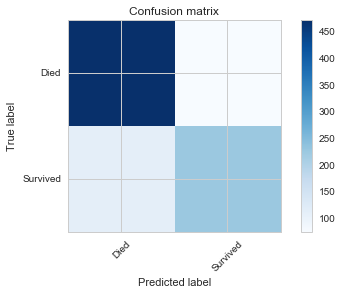

In [30]:
# Logistic Regression

logreg = LogisticRegression()
Y_predLogisticRegression = evaluate_model(logreg, X_train, Y_train, X_test)

# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

Fold Accuracies: [ 0.58426966  0.6741573   0.7247191   0.74719101  0.75141243]
Accuracy: 0.70 (+/- 0.12 @2std)
Confusion matrix, without normalization
[[450  99]
 [181 159]]


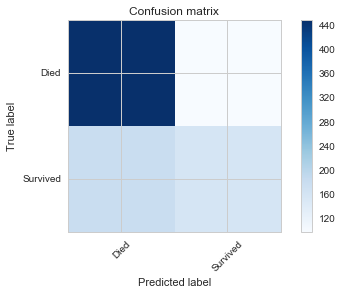

In [31]:
# Support Vector Machines

svc = SVC()
Y_predSVC = evaluate_model(svc, X_train, Y_train, X_test)

Fold Accuracies: [ 0.80898876  0.8258427   0.85955056  0.81460674  0.86440678]
Accuracy: 0.83 (+/- 0.05 @2std)
Confusion matrix, without normalization
[[494  55]
 [100 240]]


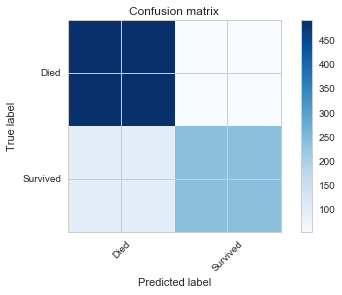

In [32]:
# Random Forests

#random_forest = RandomForestClassifier(n_estimators=100)
random_forest = RandomForestClassifier(criterion='entropy', n_estimators=50, max_depth=8, min_samples_split=8, max_features=5)
Y_predRandomForest = evaluate_model(random_forest, X_train, Y_train, X_test)

#Best: 0.814398 using {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'gini', 'n_estimators': 50, 'max_features': 2}
#Best: 0.843645 using {'criterion': 'entropy', 'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 5}


Fold Accuracies: [ 0.65168539  0.70224719  0.71910112  0.74719101  0.71186441]
Accuracy: 0.71 (+/- 0.06 @2std)
Confusion matrix, without normalization
[[433 116]
 [162 178]]


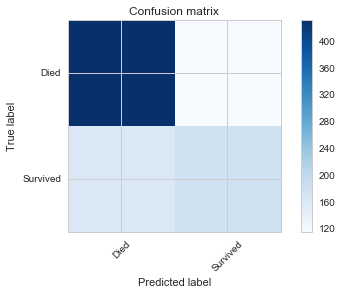

In [33]:
# K Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors = 3)
Y_predKNeighbors = evaluate_model(knn, X_train, Y_train, X_test)

Fold Accuracies: [ 0.68539326  0.7752809   0.79775281  0.78651685  0.81355932]
Accuracy: 0.77 (+/- 0.09 @2std)
Confusion matrix, without normalization
[[463  86]
 [120 220]]


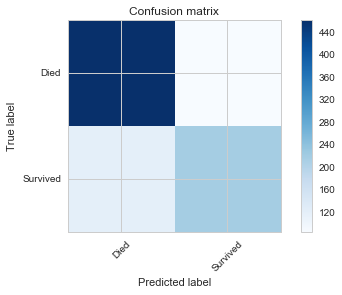

In [34]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
Y_predGaussian = evaluate_model(gaussian, X_train, Y_train, X_test)

## Hyper Parameter Tuning ##
Tuning of Random Forest model.

In [35]:
from sklearn.grid_search import GridSearchCV
param_grid = { "n_estimators"      : [50, 100, 150, 200, 250],
           "criterion"         : ["gini", "entropy"],
           "max_features"      : [2, 3, 5],
           "max_depth"         : [4, 5, 8, 10, 20],
           "min_samples_split" : [2, 4, 8]}

grid_search = GridSearchCV(random_forest, param_grid, n_jobs=1, cv=StratifiedKFold(Y_train, n_folds=5))
# grid_search.fit(X_train, Y_train)

# summarise results
#print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
#for params, mean_score, scores in grid_search.grid_scores_:
#    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
    
#Best: 0.843645 using {'criterion': 'entropy', 'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 5}


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

## Create Submission File ##

In [36]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_predRandomForest
    })
submission.to_csv('predictions.csv', index=False)